전이 학습(Transfer Learning)은 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것을 의미.

전이 학습은 학습 데이터의 수가 적을때도 효과적이며, 학습 속도도 빠름.

# 데이터 다운로드

```
flower 종류
- daisy
- dandelion
- rose
- sunflower
- tulip
```

In [6]:
!pwd

/content


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!cp /content/gdrive/MyDrive/tmp/flowers_prepared.zip ./

In [9]:
!unzip flowers_prepared.zip

Archive:  flowers_prepared.zip
   creating: flowers_prepared/test/
   creating: flowers_prepared/test/daisy/
  inflating: flowers_prepared/test/daisy/401.jpg  
  inflating: flowers_prepared/test/daisy/402.jpg  
  inflating: flowers_prepared/test/daisy/403.jpg  
  inflating: flowers_prepared/test/daisy/404.jpg  
  inflating: flowers_prepared/test/daisy/405.jpg  
  inflating: flowers_prepared/test/daisy/406.jpg  
  inflating: flowers_prepared/test/daisy/407.jpg  
  inflating: flowers_prepared/test/daisy/408.jpg  
  inflating: flowers_prepared/test/daisy/409.jpg  
  inflating: flowers_prepared/test/daisy/410.jpg  
  inflating: flowers_prepared/test/daisy/411.jpg  
  inflating: flowers_prepared/test/daisy/412.jpg  
  inflating: flowers_prepared/test/daisy/413.jpg  
  inflating: flowers_prepared/test/daisy/414.jpg  
  inflating: flowers_prepared/test/daisy/415.jpg  
  inflating: flowers_prepared/test/daisy/416.jpg  
  inflating: flowers_prepared/test/daisy/417.jpg  
  inflating: flowers_pre

# 학습

In [10]:
# for i in range(10):
#   print(i)

# numbers = [1,2,3,4,5,6,7,8,10]
# for i in numbers:
#   print(i)
  

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 256)               17662208  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 25,433,086
Trainable params: 17,664,005
N

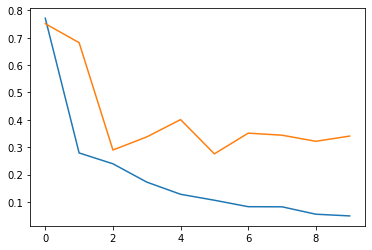

4/4 [==============================] - 1s 120ms/step - loss: 0.3406 - acc: 0.8910
loss= 0.34055858850479126
acc= 0.8909952640533447


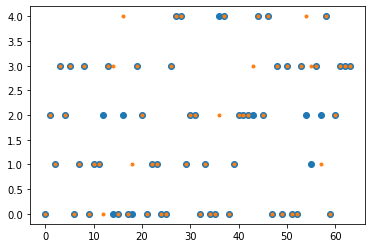

label category index = 0.0
predicted category index = 0
predicted category name = daisy


In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))  # CHAGE <---------------------------- flower 종류 5개

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()


# 증식(데이터 확장) / 검증 데이터는 증식되어서는 안됨.
BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "flowers_prepared/train",  # CHAGE <----------------------------
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "flowers_prepared/test",  # CHAGE <----------------------------
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)


train_x, train_y = train_data_generator.next()   # ADD <-----------------
test_x, test_y = test_data_generator.next()
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# 추후 추가 부분

# Callback 이용

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

import time

## loss 실시간 출력

In [13]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

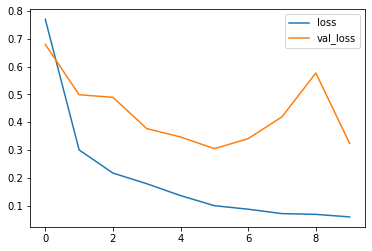

loss =  0.05907773599028587 , val_loss =  0.32364264130592346


In [14]:
preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False


model = keras.Sequential()
model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, vertical_flip=False,
                                          preprocessing_function=preprocessor).flow_from_directory(
                                          "flowers_prepared/train", target_size=(224,224), batch_size=BATCH_SIZE,
                                          class_mode='sparse')

test_data_generator = ImageDataGenerator(preprocessing_function=preprocessor).flow_from_directory(
    "flowers_prepared/test", target_size=(224,224), batch_size=BATCH_SIZE, class_mode='sparse')

plot_losses = PlotLosses()

model.fit(train_data_generator, validation_data=test_data_generator, epochs=10, verbose=0, batch_size=BATCH_SIZE, callbacks=[plot_losses])

# 모델 저장
베스트 모델 저장(callback)

In [15]:

from tensorflow.keras.callbacks import ModelCheckpoint
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# save_best_only=True인 경우 베스트 모델 저장
# save_best_only=False인 경우 마지막 모델 저장


# model.fit(train_x, train_y, epochs=1000, verbose=0, batch_size=20, validation_split=0.1)
model.fit(train_data_generator, validation_data=test_data_generator, epochs=10, verbose=0, batch_size=20, callbacks=[model_check_point])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# 최적합 모델로 다시 돌려보기

VGG 전이학습

## 모델 불러오기

In [16]:
from tensorflow import keras 
model = keras.models.load_model('/content/best_model.h5')

Found 211 images belonging to 5 classes.


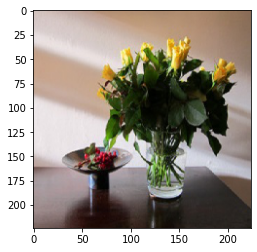

test_y = 2 , predicted = 2


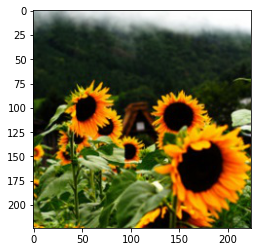

test_y = 3 , predicted = 3


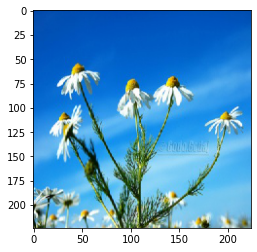

test_y = 0 , predicted = 4


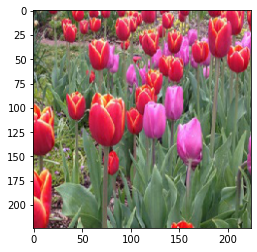

test_y = 4 , predicted = 4


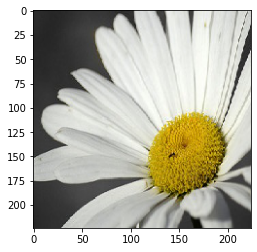

test_y = 0 , predicted = 0


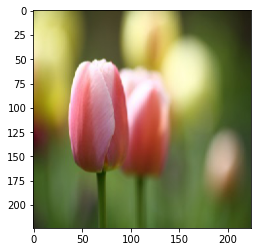

test_y = 4 , predicted = 4


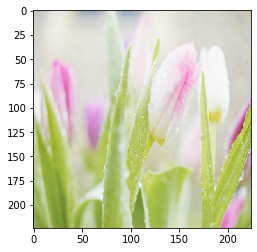

test_y = 4 , predicted = 4


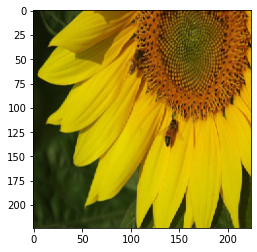

test_y = 3 , predicted = 0


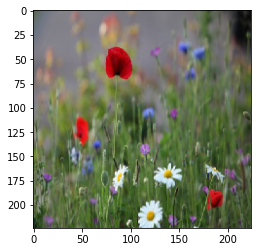

test_y = 0 , predicted = 0


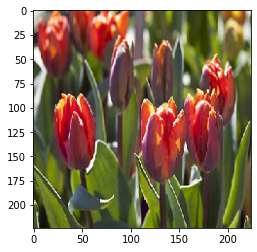

test_y = 4 , predicted = 4


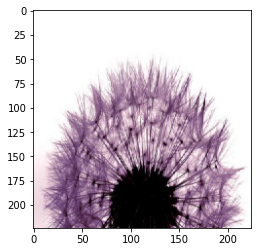

test_y = 1 , predicted = 1


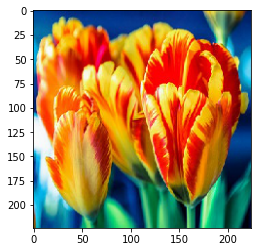

test_y = 4 , predicted = 4


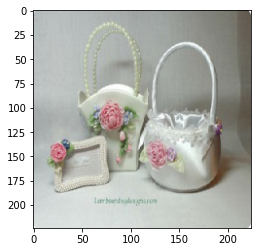

test_y = 2 , predicted = 2


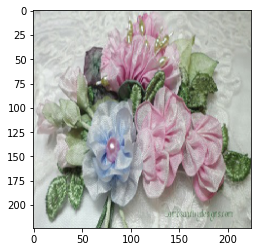

test_y = 2 , predicted = 2


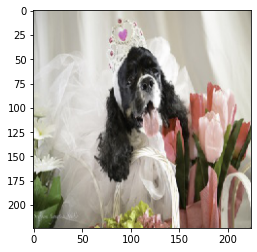

test_y = 4 , predicted = 2


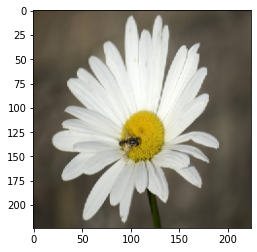

test_y = 0 , predicted = 0


In [17]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16


test_data_generator = ImageDataGenerator(
      # 원 이미지를 그려주기 위해 전처리 함수를 사용 하지 않은 이미지를 읽는다.
      # 모델 호출 시에 직접 전처리 함수를 호출한다.
      # preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "flowers_prepared/test",
      target_size=(224,224),
      batch_size=16,
      class_mode='sparse')


while True:
  # 한번에 batch_size 16개 만큼 꺼낸다.
  # test_x와 test_y에는 16개가 담겼다.
  test_x, test_y = next(test_data_generator)

  # 모델 호출하기 위해 전처리 함수를 호출하고
  preprocessed_test_x = vgg16.preprocess_input(test_x.copy())

  # 모델로 예측 하고
  y_ = model.predict(preprocessed_test_x)

  # category index를 구한다.
  predicted = np.argmax(y_, axis=1)

  # 16개 이미지에 대하여 각각 그려보고 정답과 예측 값을 출력한다.
  for i, a_image in enumerate(test_x):
    plt.imshow(a_image/255.0)
    plt.show()
    print("test_y =", test_y.astype(int)[i], ", predicted =", predicted[i])
  break